### Strategy

- As the bank-additional dataset is a higher dimensional dataset, even without the not so useful poutcome field, would be using that dataset for the initial analysis
- The default field has a high unbalance and should be dropped
- The pdays field can be tried initially, but can also be dropped if required later
- Convert the 10 categorical features into one-hot encoding
- Add promising transformations of features
- standard scaler transformation of the numerical features
- Aggregate features into promising new features (maybe try some dimensionality reduction techniques on the highly correlated features to create some new reduced feature)

In [163]:
import pandas as pd 

df = pd.read_csv('../mount/Data_Manipulation_datasets/train.csv')

In [164]:
import numpy as np 
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class PrevPdayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def discretize_pdays(self, pdays):
        if pdays < 30:
            return pdays + 1
        if pdays == 999:
            return 0
        if pdays < 999:
            return 31
        if pdays > 999:
            return 32
        
    def discretize_previous(self, previous):
        if previous < 10:
            return previous
        else:
            return 10
        
    def transform(self, X):
        X['pdays'] = X['pdays'].apply(self.discretize_pdays)
        X['previous'] = X['previous'].apply(self.discretize_previous)
        return X

In [170]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class EngineerFeatures():
    def __init__(self):
        self.num_pipeline_1 = Pipeline([
            ('prev_n_pday', PrevPdayTransformer()),
            ('log_transform', FunctionTransformer(np.log1p, validate=True)),
            ('std_scaler', StandardScaler()),
        ])
        
        self.num_pipeline_2 = Pipeline([
            ('std_scaler', StandardScaler()),
        ])
        
    def transform(self, df):
        # drop column 'default' and get the target variable 
        Y = df['y']
        X_df = df.drop(['default', 'y'], axis=1)
        
        # separate the numerical and categorical columns names 
        num_df_cols = X_df.select_dtypes(include=['int64', 'float64']).columns
        cat_df_cols = X_df.select_dtypes(include=['object']).columns
        num_pipeline_1_cols = ['duration', 'campaign', 'pdays', 'previous']
        num_pipeline_2_cols = list(set(num_df_cols) - set(num_pipeline_1_cols))
        
        # define the full pipeline
        full_pipeline = ColumnTransformer([
            ('num1', self.num_pipeline_1, num_pipeline_1_cols),
            ('num2', self.num_pipeline_2, num_pipeline_2_cols),
            ('one-hot-encoder', OneHotEncoder(), cat_df_cols),
        ])
        
        # Label encoding the target variable
        Y = Y.map({'no': 0, 'yes': 1})
        X = full_pipeline.fit_transform(X_df)
        
        return X, Y, full_pipeline

In [171]:
feature_engineer = EngineerFeatures()

X, Y, full_pipeline = feature_engineer.transform(df)

In [172]:
full_pipeline

ColumnTransformer(transformers=[('num1',
                                 Pipeline(steps=[('prev_n_pday',
                                                  PrevPdayTransformer()),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['duration', 'campaign', 'pdays', 'previous']),
                                ('num2',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['nr.employed', 'emp.var.rate',
                                  'cons.price.idx', 'euribor3m', 'age',
                                  'cons.conf.idx']),
                                ('one-hot-encoder', OneHotEncoder(),
                                 Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome'],
      dtype='object'))])

In [179]:
full_pipeline.transformers_[0][1].named_steps['std_scaler'].var_

array([0.84156287, 0.24236153, 0.1471358 , 0.07985921])

### Rough work

In [143]:
import pandas as pd 

df = pd.read_csv('../mount/Data_Manipulation_datasets/train.csv')

In [144]:
new_df = df.drop(['default', 'y'], axis=1)
Y_df = df['y']

In [145]:
# create two new dataframes one with all the numerical columns and the other with all the categorical columns
numerical_df = new_df.select_dtypes(include=['int64', 'float64'])
categorical_df = new_df.select_dtypes(include=['object'])

In [146]:
# convert the categorical columns to one-hot encoding
print(categorical_df.shape)
categorical_df = pd.get_dummies(categorical_df)
print(categorical_df.shape)

(32940, 9)
(32940, 50)


In [147]:
# replace the 'yes' and 'no' in the target column to 1 and 0
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()
Y_df = label_encoder.fit_transform(Y_df)
{ class_label: label_encoder.transform([class_label])[0] for class_label in label_encoder.classes_}

{'no': 0, 'yes': 1}

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>],
       [<Axes: title={'center': 'cons.price.idx'}>,
        <Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>],
       [<Axes: title={'center': 'nr.employed'}>, <Axes: >, <Axes: >]],
      dtype=object)

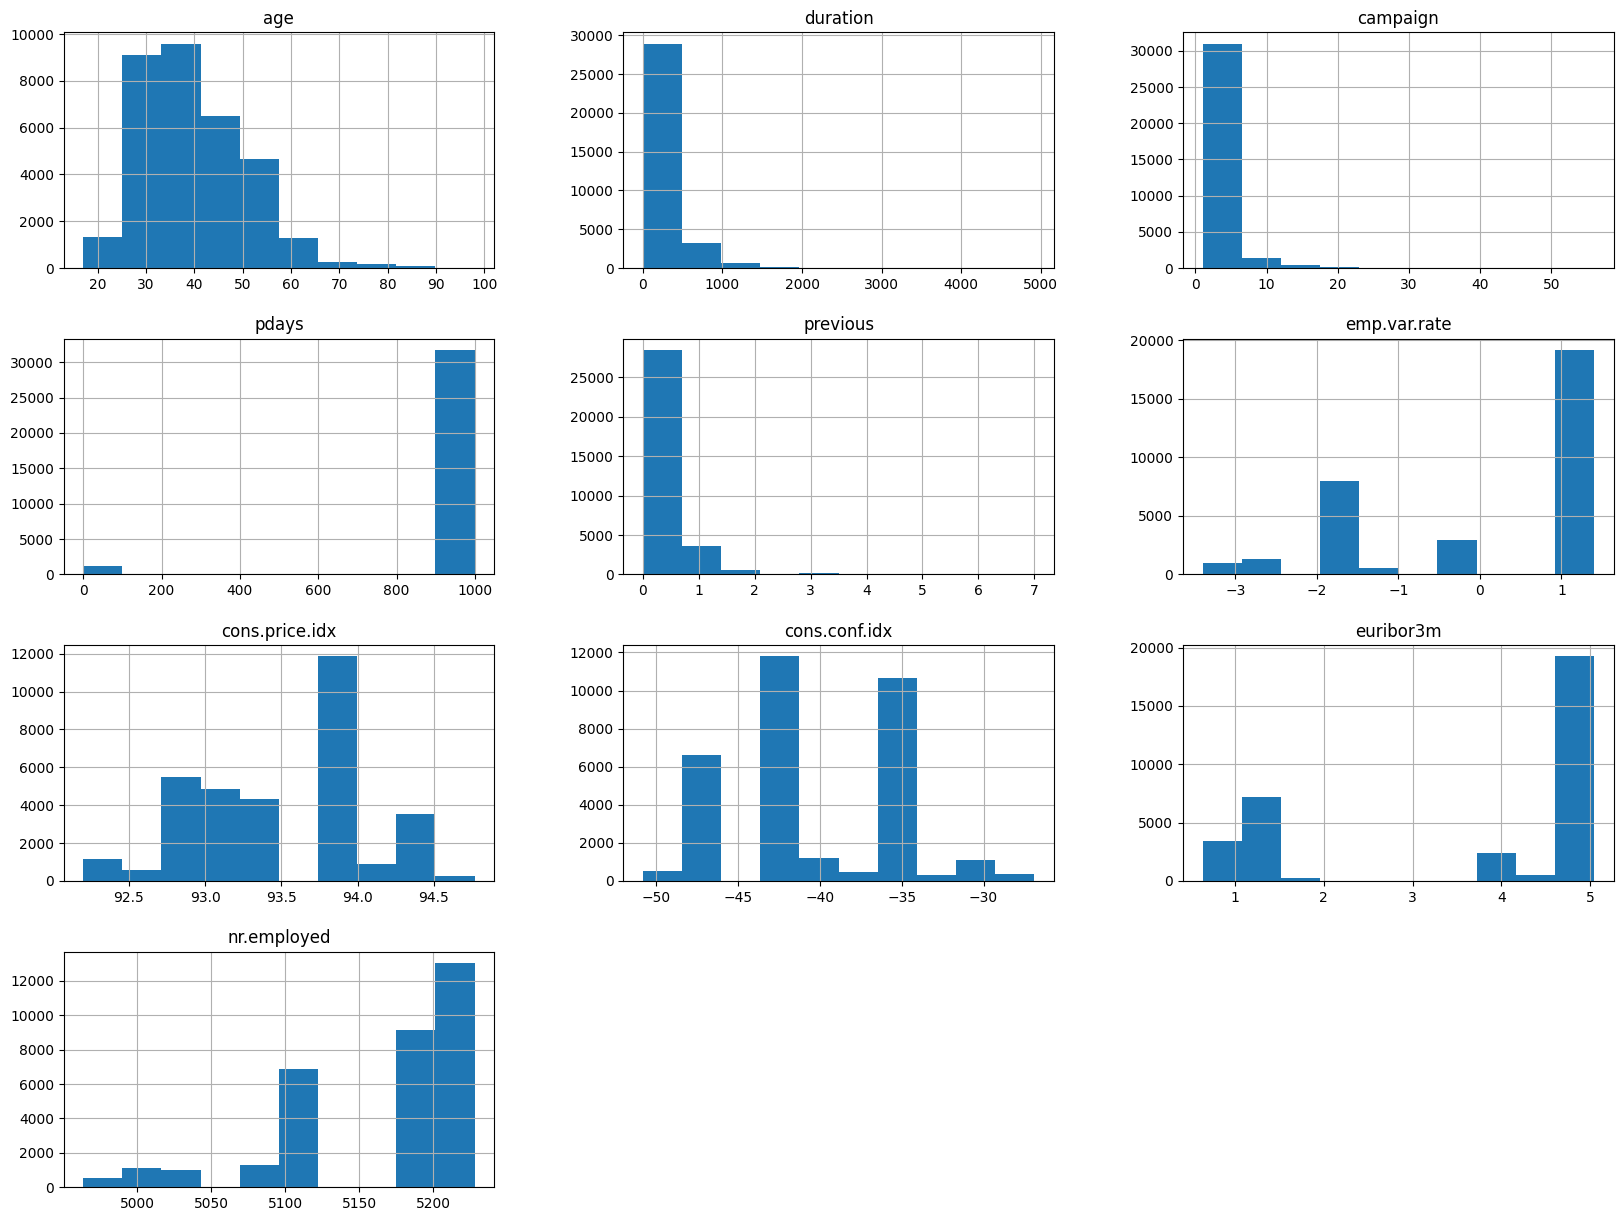

In [148]:
numerical_df.hist(figsize=(20, 15))

In [149]:
# feature transformation of the not so well distributed numerical columns

import numpy as np 
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class PrevPdayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def discretize_pdays(self, pdays):
        if pdays < 30:
            return pdays + 1
        if pdays == 999:
            return 0
        if pdays < 999:
            return 31
        if pdays > 999:
            return 32
        
    def discretize_previous(self, previous):
        if previous < 10:
            return previous
        else:
            return 10
        
    def transform(self, X):
        X['pdays'] = X['pdays'].apply(self.discretize_pdays)
        X['previous'] = X['previous'].apply(self.discretize_previous)
        return X
    
numerical_df = PrevPdayTransformer().transform(numerical_df)

transformer = FunctionTransformer(np.log1p, validate=True)

numerical_df['duration'] = transformer.transform(numerical_df[['duration']])
numerical_df['campaign'] = transformer.transform(numerical_df[['campaign']])
numerical_df['pdays'] = transformer.transform(numerical_df[['pdays']])
numerical_df['previous'] = transformer.transform(numerical_df[['previous']])

c:\Users\aanur\projects\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
c:\Users\aanur\projects\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
c:\Users\aanur\projects\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
c:\Users\aanur\projects\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>],
       [<Axes: title={'center': 'cons.price.idx'}>,
        <Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>],
       [<Axes: title={'center': 'nr.employed'}>, <Axes: >, <Axes: >]],
      dtype=object)

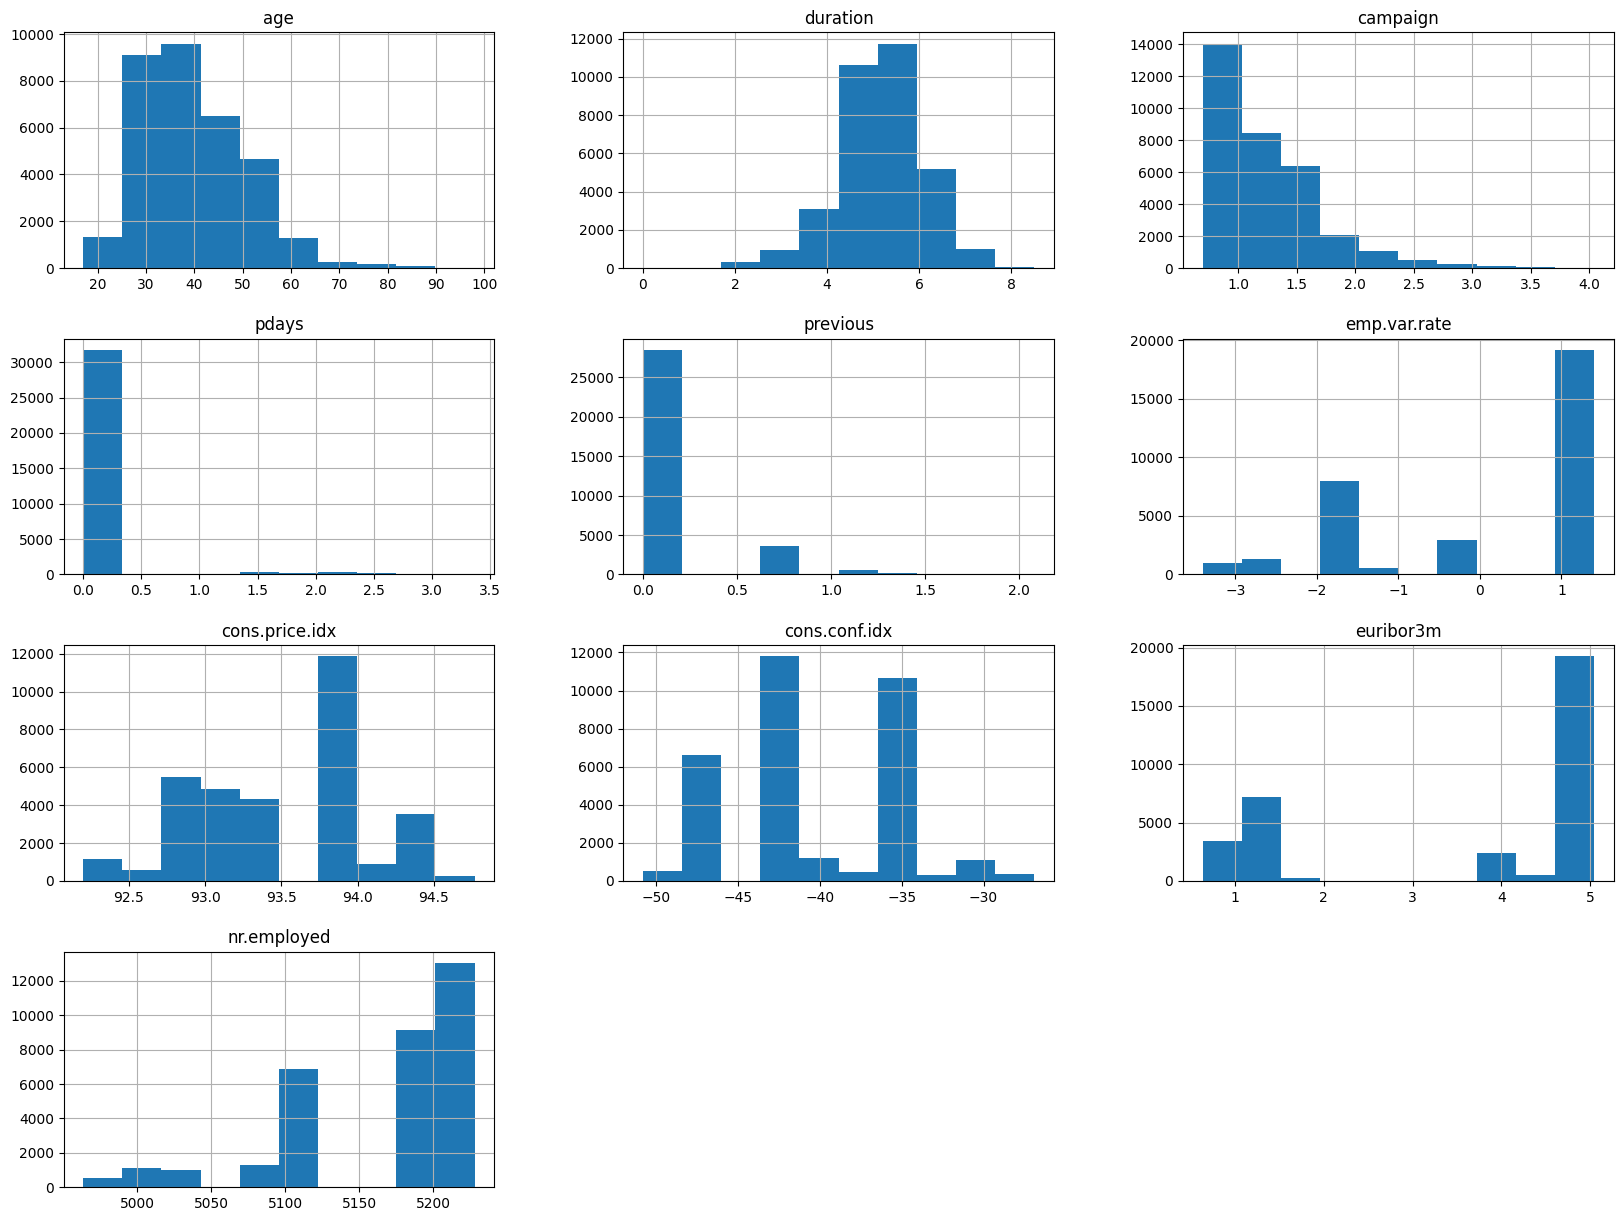

In [150]:
numerical_df.hist(figsize=(20, 15))

In [151]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns=numerical_df.columns)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>],
       [<Axes: title={'center': 'cons.price.idx'}>,
        <Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>],
       [<Axes: title={'center': 'nr.employed'}>, <Axes: >, <Axes: >]],
      dtype=object)

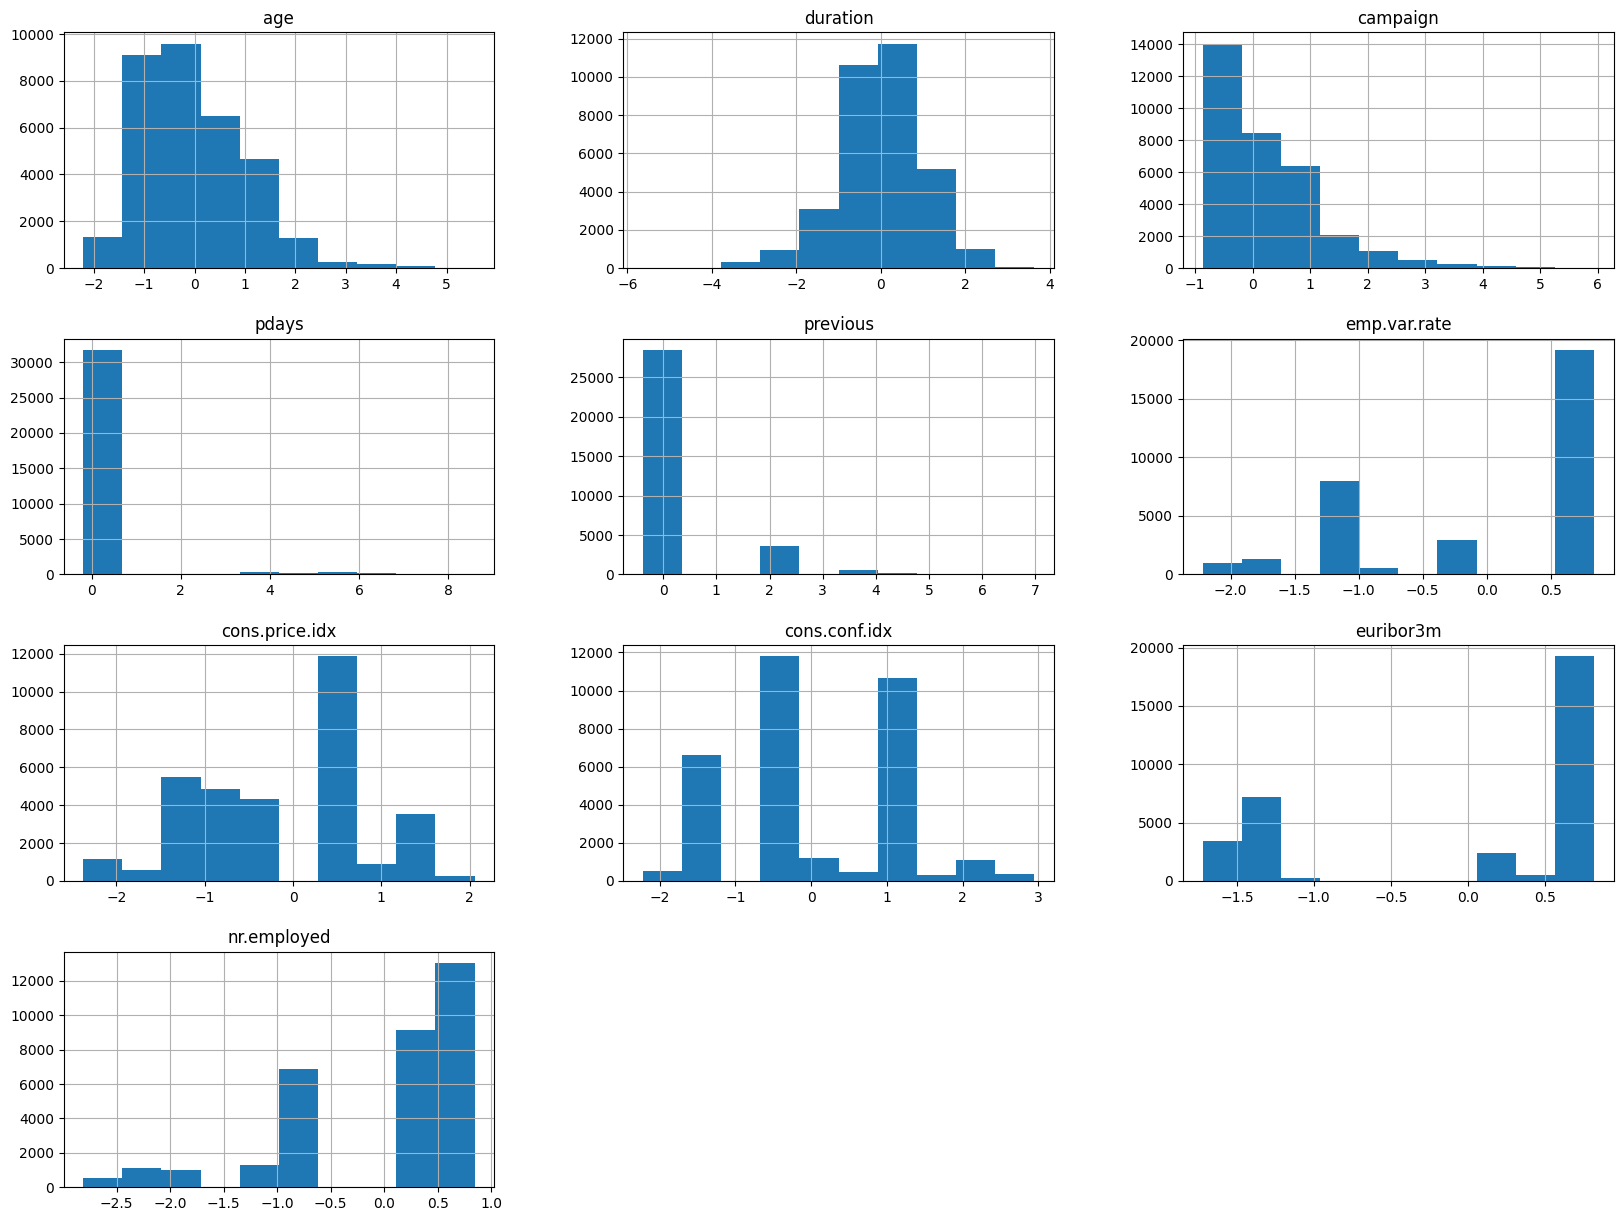

In [152]:
numerical_df.hist(figsize=(20, 15))